In [11]:
from skimage.morphology import disk
import matplotlib.pyplot as plt
from pylab import rcParams
import scipy.ndimage as nd
from PIL import Image
from queue import Queue
import pandas as pd
import numpy as np

rcParams['figure.figsize'] = 10, 20

In [12]:
_df = pd.read_csv("D:\Godis\Projects\SampleCoreAnalysisPresentation\data.csv")

In [13]:
df = _df[_df["PhotoType"] == "ДС"]
# df = df.iloc[[0,5,1500,2500]]
df = df[1500:1520]

In [17]:
from os import listdir
names = listdir("D:\Godis\Projects\SampleCoreAnalysisPresentation\cracksData")
ids = list(map(lambda x: x.split(".")[0], names))

df = _df[_df["PhotoType"] == "ДС"]
df = df[df["Id"].isin(ids)]

In [18]:
AREA_R_ABS = 0.5       # sm
AREA_HOLE_R_ABS = 0.35 # sm
INFL_AREA_R = 0.25     # sm
RESOLUTION = 20        # px/sm

CRACK_TR_KOEF = 0.65  # -
SRC_TR = 20           # value from [0; 256]
CRACK_TR = 60         # value from [0; 256]

AREA_R = int(AREA_R_ABS*RESOLUTION)            # px
AREA_HOLE_R = int(AREA_HOLE_R_ABS*RESOLUTION)  # px
INFL_AREA_R = int(INFL_AREA_R*RESOLUTION)      # px

WORK_DIR = "D:/Godis/Projects/SampleCoreAnalysisPresentation"



In [19]:
def scaleImg(img, absH, res):
    koef = (absH/img.size[1])*res
    # first - width, second - height
    return img.resize((int(img.size[0]*koef), int(img.size[1]*koef)))

In [20]:
def cropBorders(img, res):
    cropSM = 2
    cropPX = int(2*res)
    return img[:, cropPX:-cropPX]

In [21]:
def crackMask(gray):
    npFG = np.empty_like(gray)
    
    n = AREA_R
    m = AREA_HOLE_R
    weights = disk(n)
    middle = disk(m)
        
    # filter kernel
    weights[n-m:n+m+1,n-m:n+m+1] = np.logical_and(weights[n-m:n+m+1,n-m:n+m+1], np.logical_not(middle))
    weights = weights/np.sum(weights)
    
    # for each pixel find middle value in the local area
    midGray = nd.convolve(gray, weights, output=None, mode='reflect', cval=0.0, origin=0)
    
    # select all pixels, which are less, than alpha*(middle value) in local area
    # and which are less than tresh value
    mask = np.logical_and(gray < (CRACK_TR_KOEF*midGray), gray < CRACK_TR)
    mask = np.logical_or(mask, gray < SRC_TR)
    
    npFG[mask] = 127
    npFG[np.logical_not(mask)] = 255
    
    q = Queue()
    n = INFL_AREA_R
    area = disk(n)
    for i in range(npFG.shape[0]):
        for j in range(npFG.shape[1]):
            if (gray[i,j] < SRC_TR):
                q.put((i, j))
                
    while q.qsize() > 0:
        y, x = q.get()
        for i in range(-n,n+1):
            for j in range(-n,n+1):
                if (i+y < 0 or j+x < 0 or i+y >= npFG.shape[0] or j+x >= npFG.shape[1]):
                    continue
                if (area[i+n,j+n]==0):
                    continue
                if (npFG[y+i,x+j]==127):
                    npFG[y+i,x+j] = 0
                    q.put((y+i,x+j))
                    
    npFG[npFG == 127] = 255
    
    return npFG

1000000 image
1000004 image
1000010 image
1000028 image
1000040 image
1000072 image
1000148 image
1000184 image
1000212 image
1000348 image
1000354 image
1000362 image
1000412 image
1000474 image
1000690 image
1000838 image
1000854 image
1000928 image
1000934 image
1001370 image
1001392 image


D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1001406 image
1001414 image
1001450 image
1000000 image
1000004 image
1000010 image
1000028 image
1000040 image
1000072 image
1000148 image
1000184 image
1000212 image
1000222 image
1000256 image
1000306 image
1000334 image
1000348 image
1000354 image
1000362 image
1000412 image
1000474 image
1000690 image
1000838 image
1000854 image
1000928 image
1000934 image
1000966 image
1001060 image
1001066 image
1001070 image
1001080 image
1001082 image
1001088 image
1001092 image
1001120 image
1001154 image
1001370 image
1001392 image
1001406 image
1001414 image
1001450 image


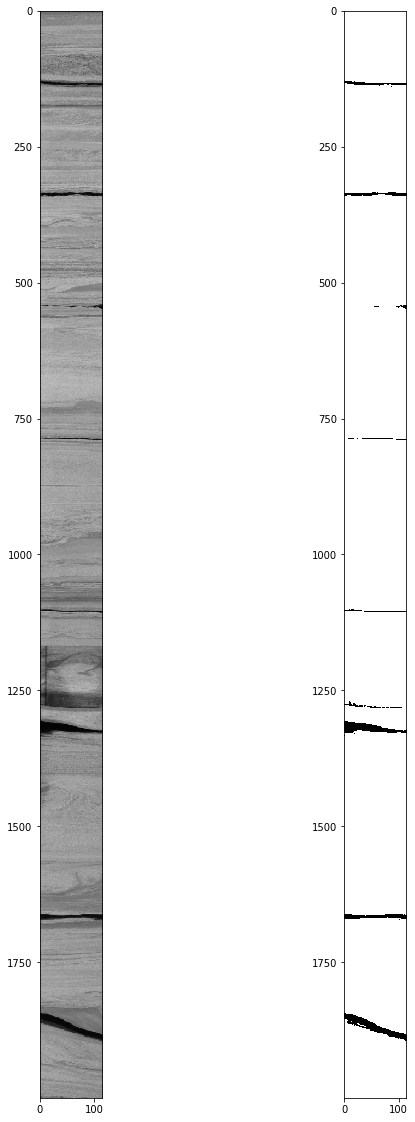

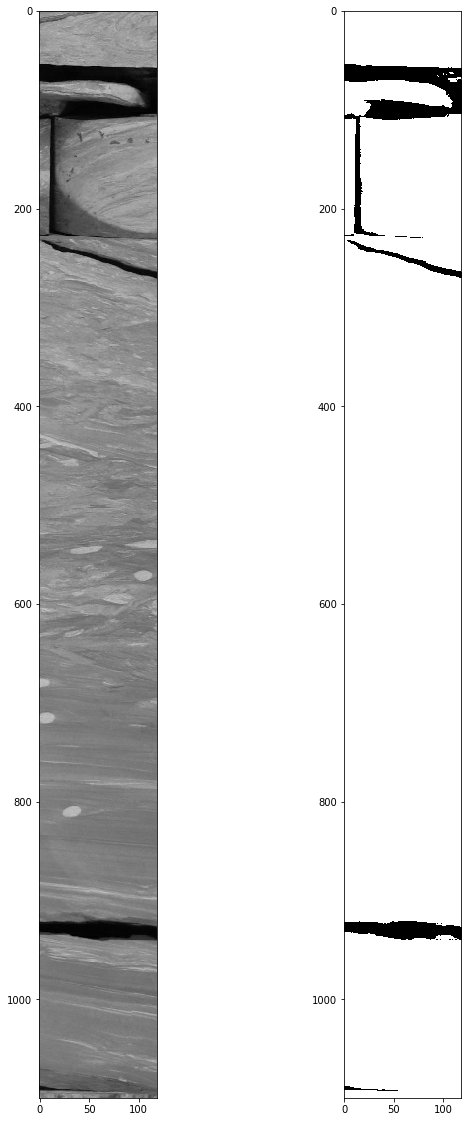

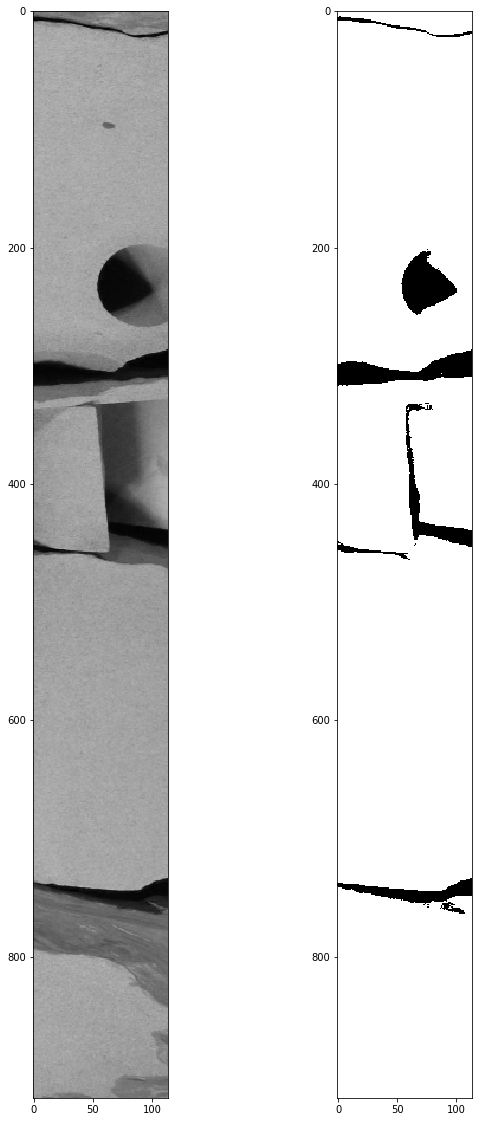

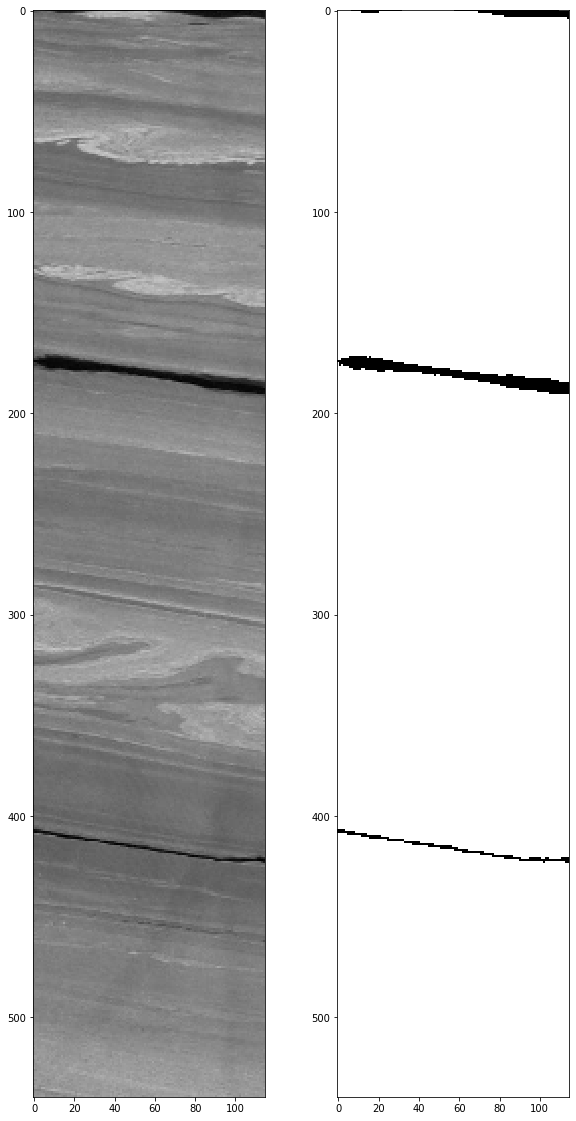

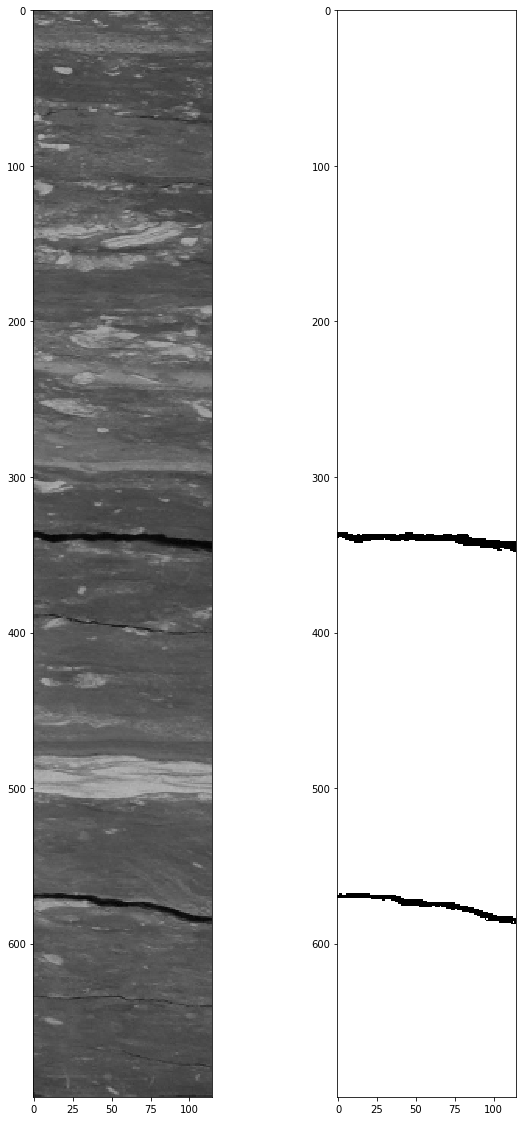

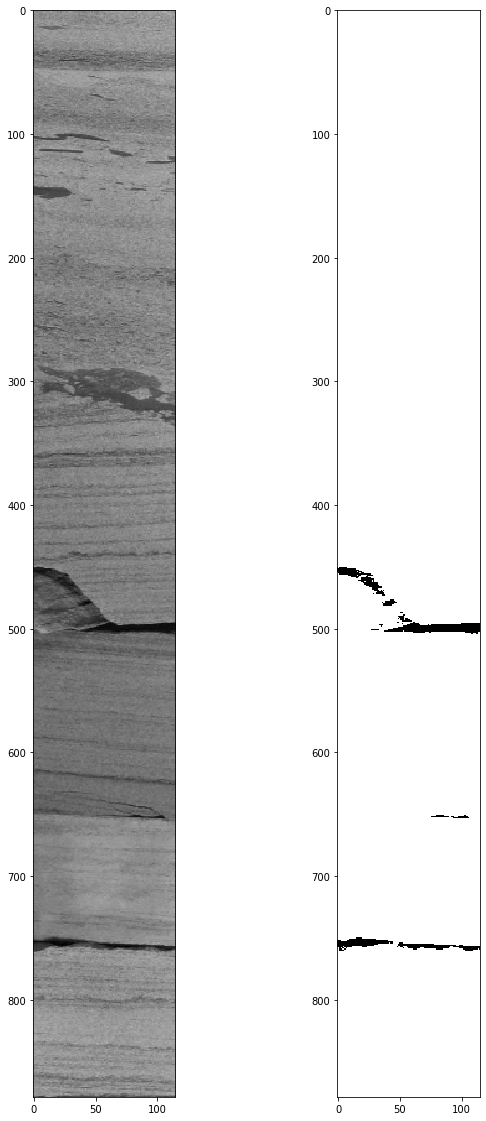

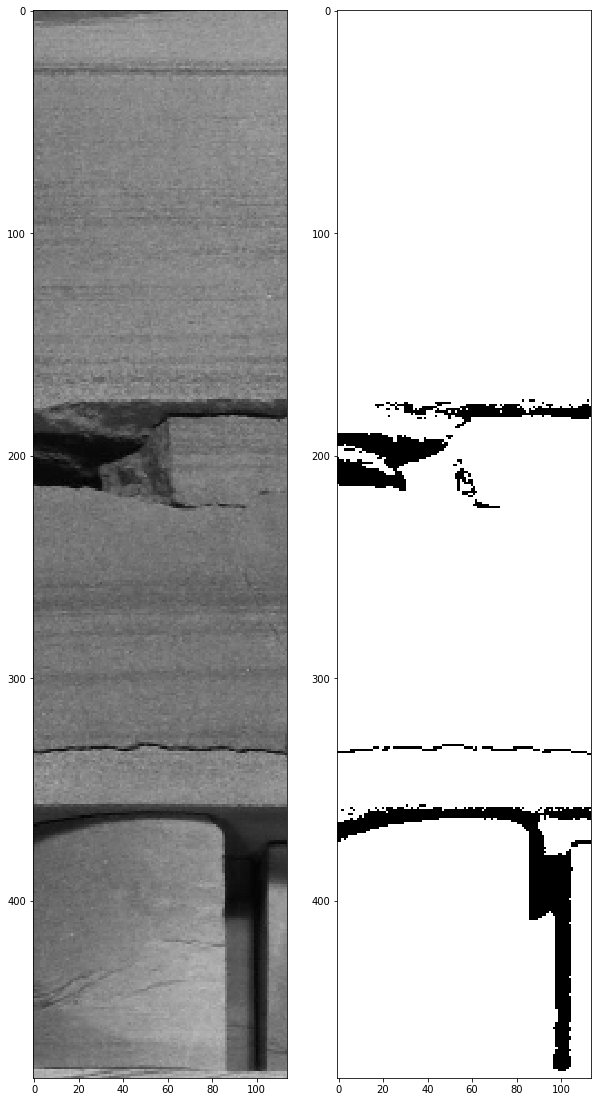

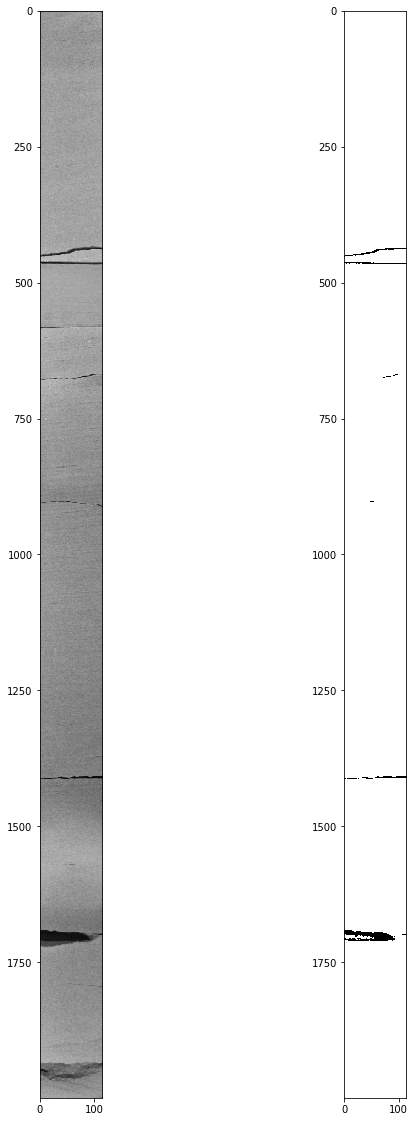

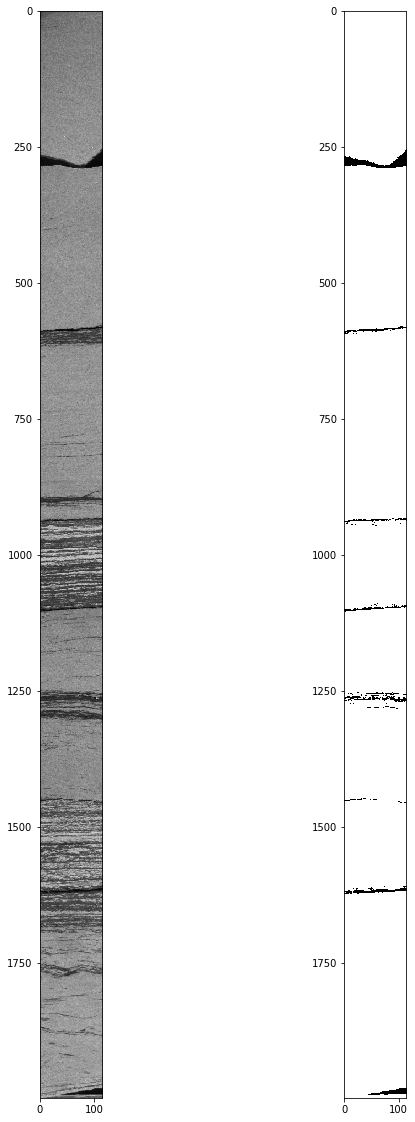

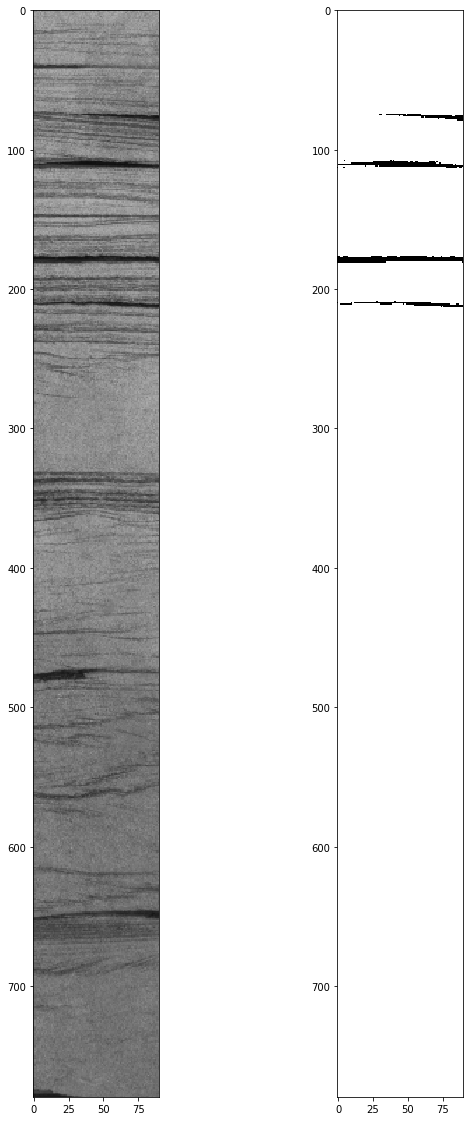

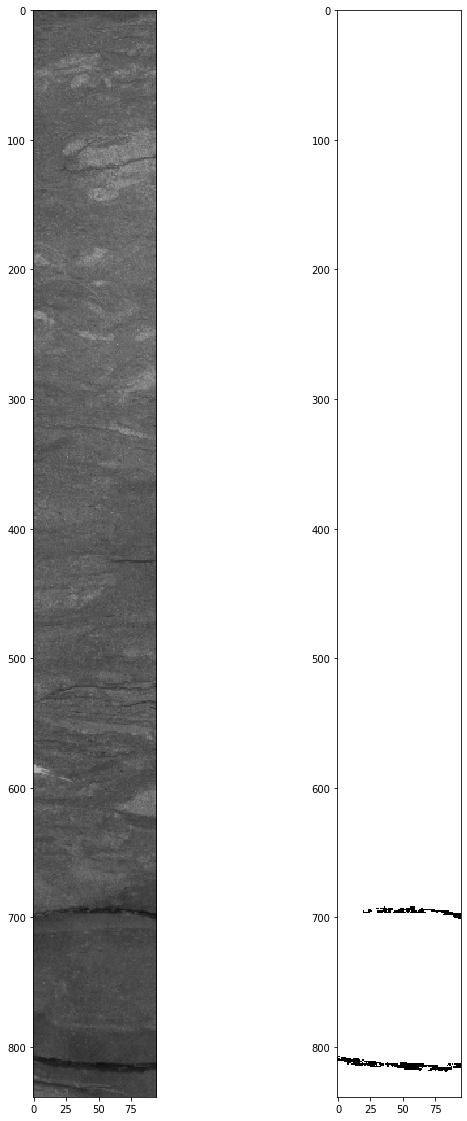

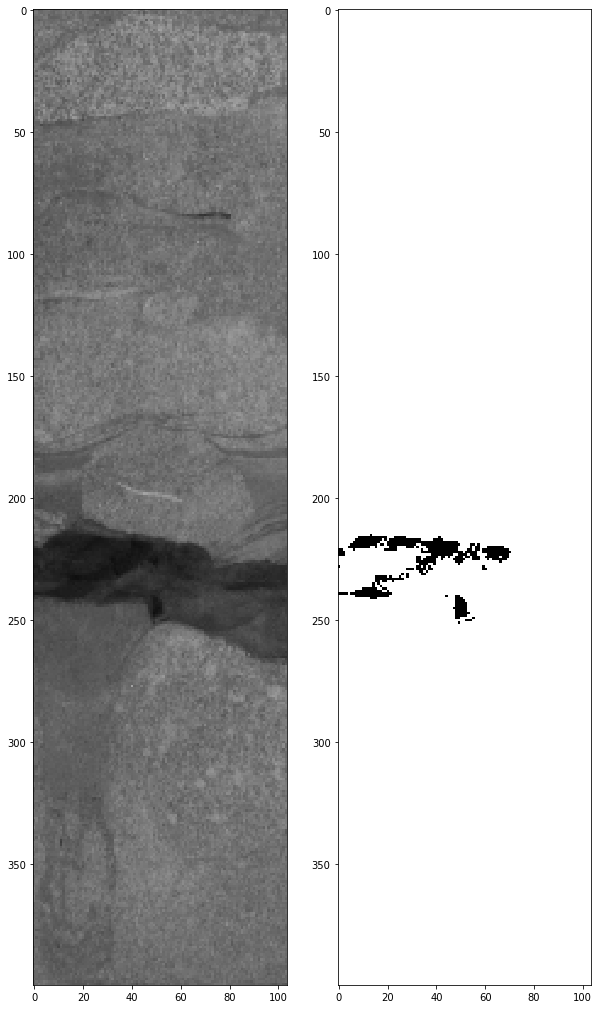

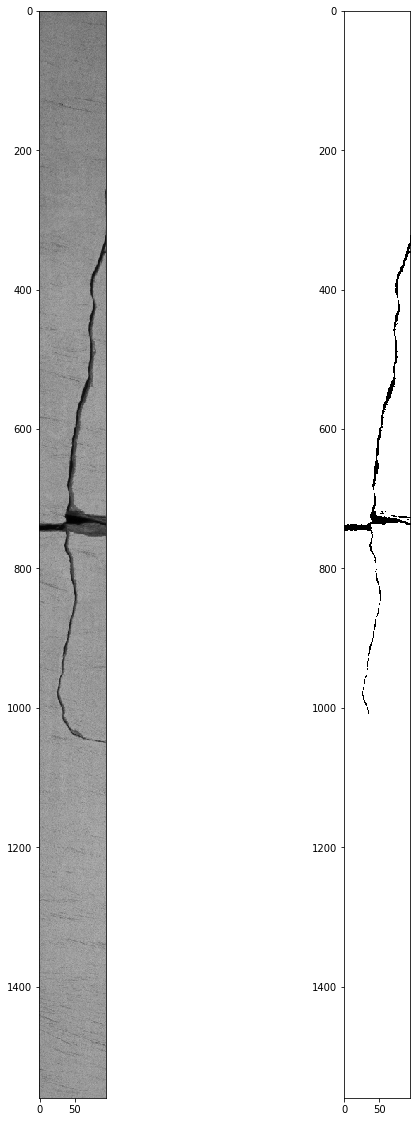

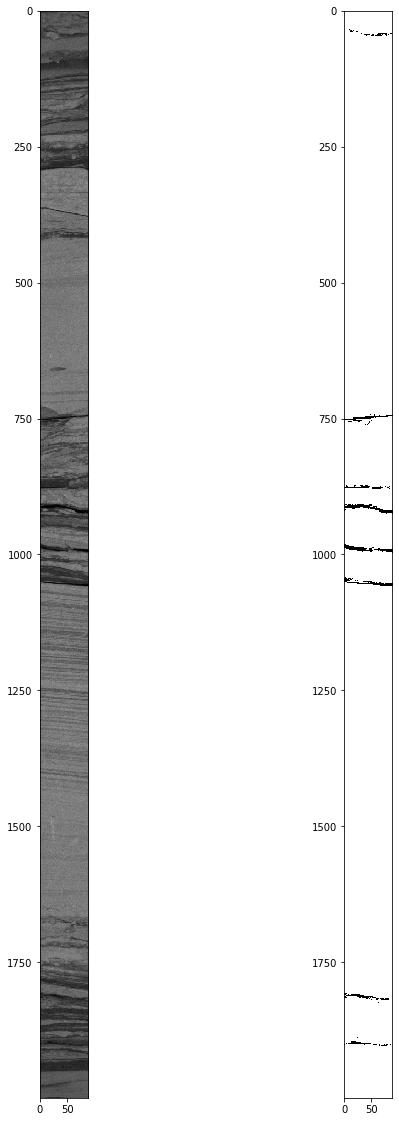

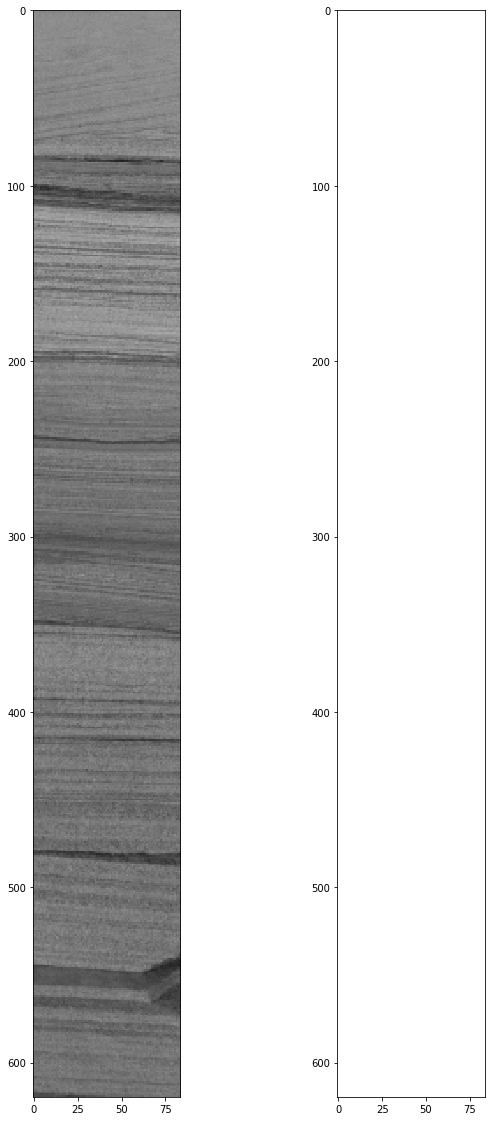

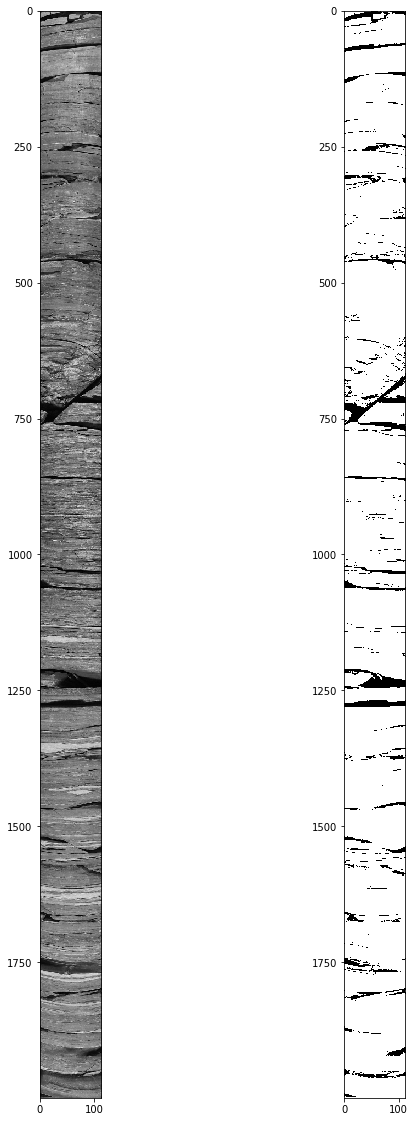

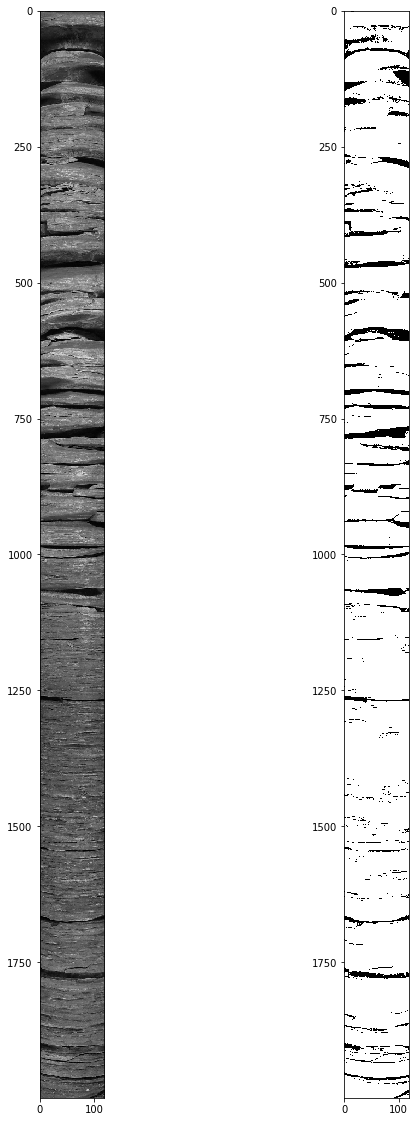

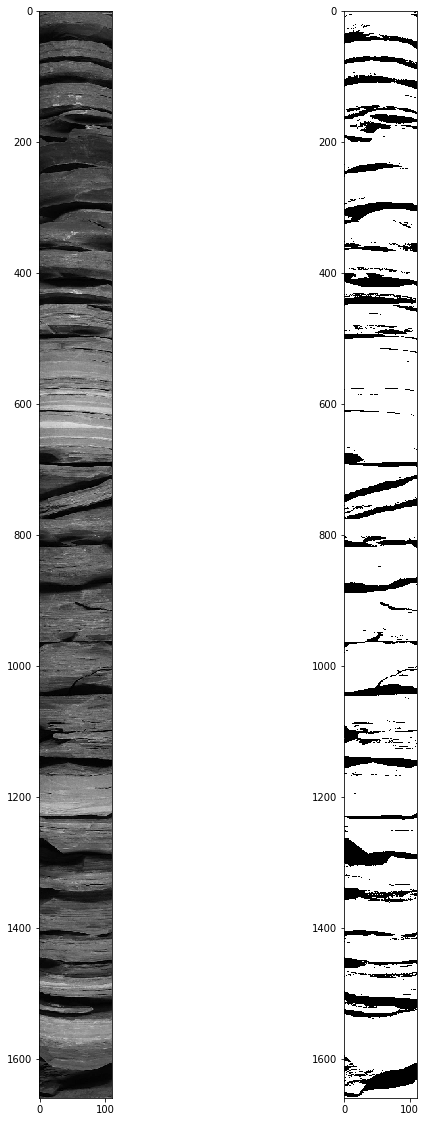

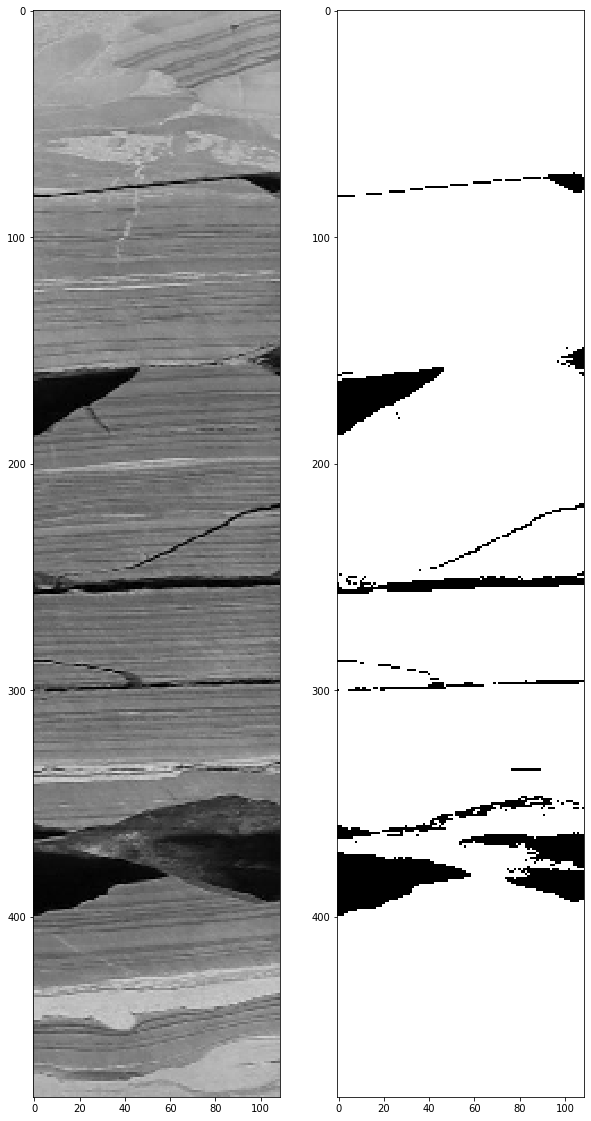

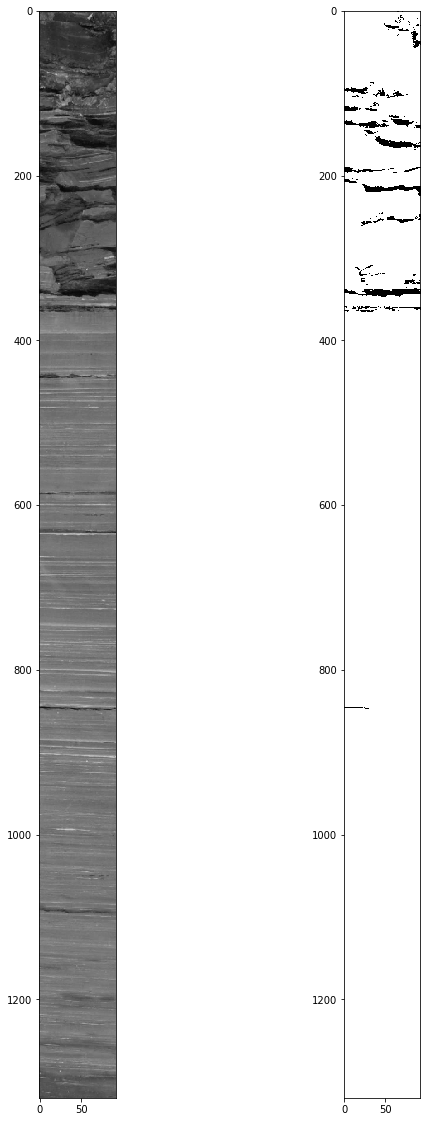

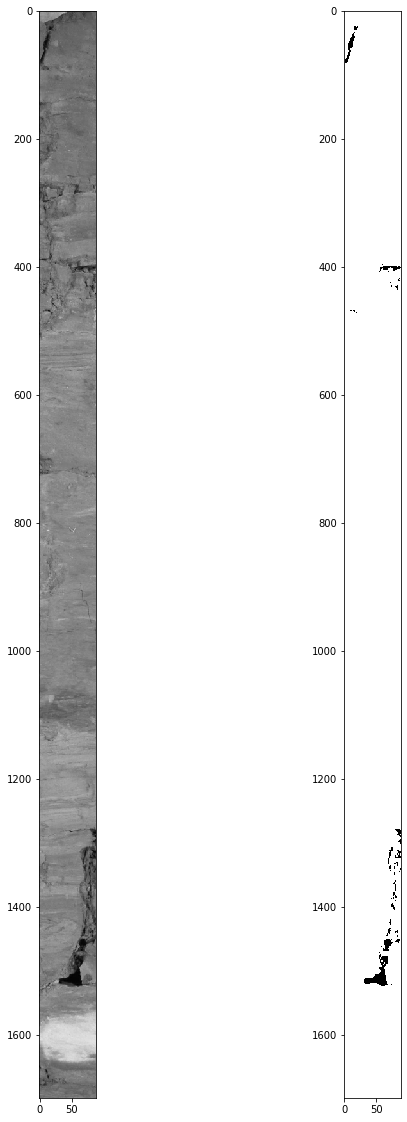

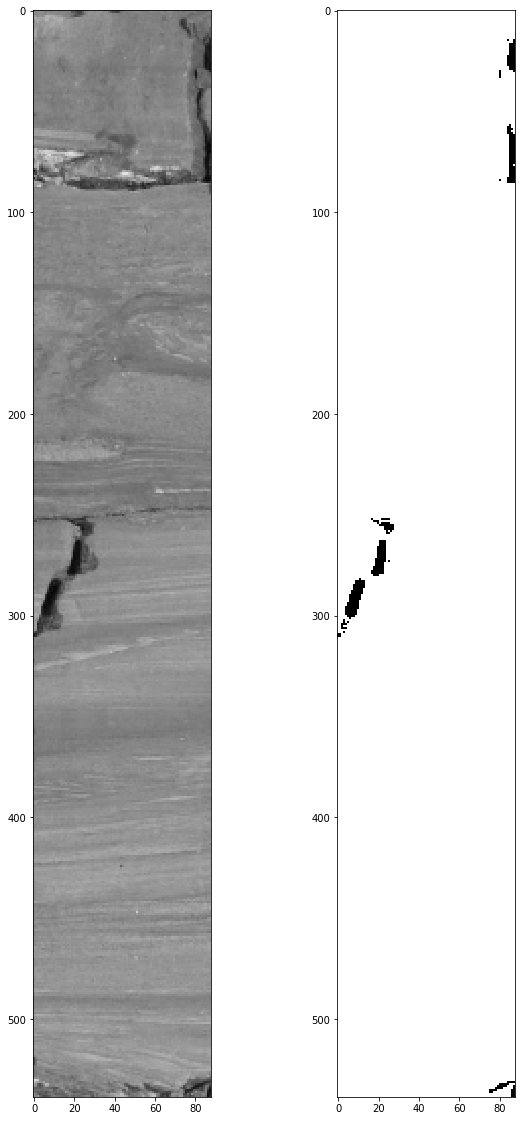

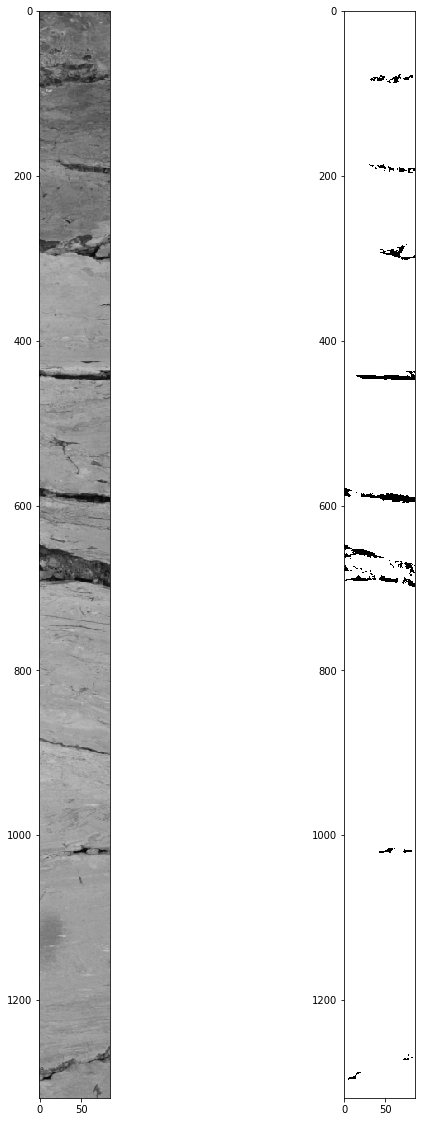

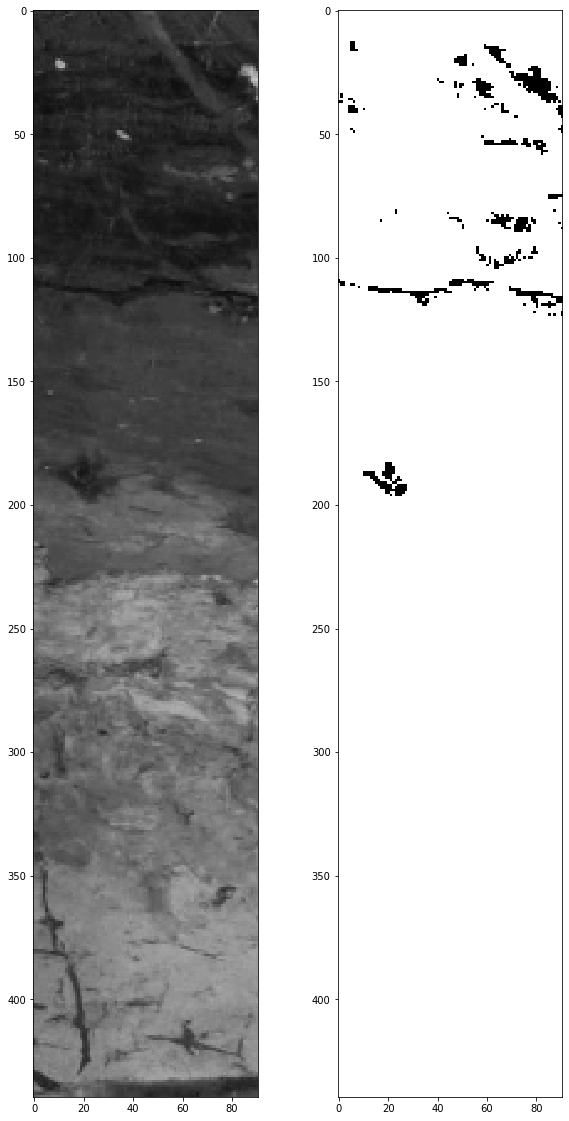

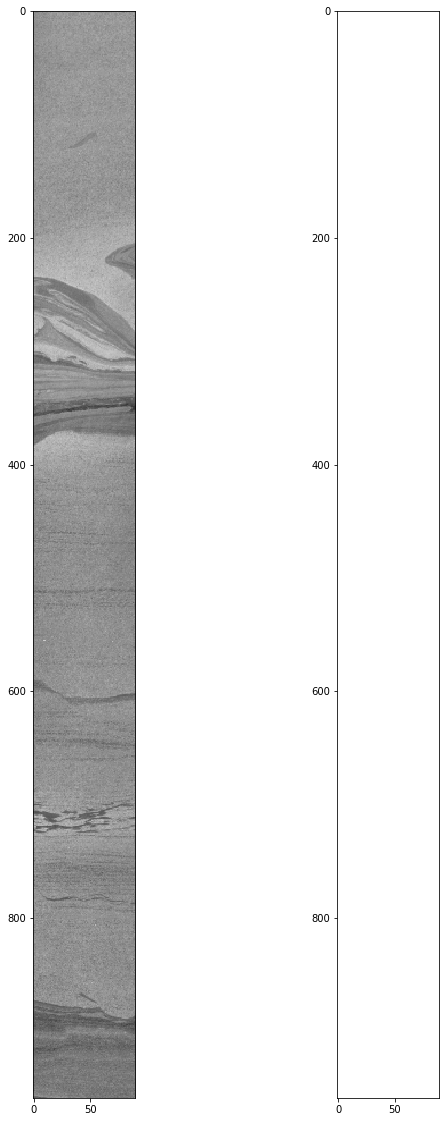

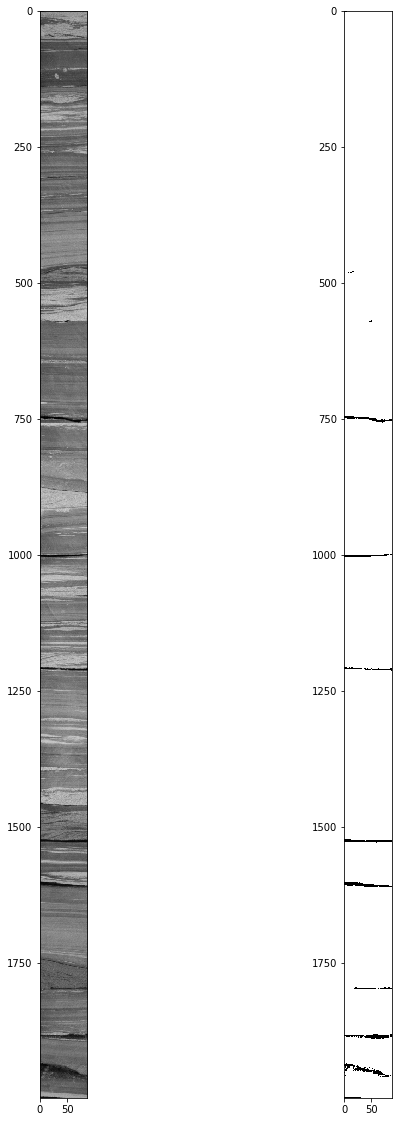

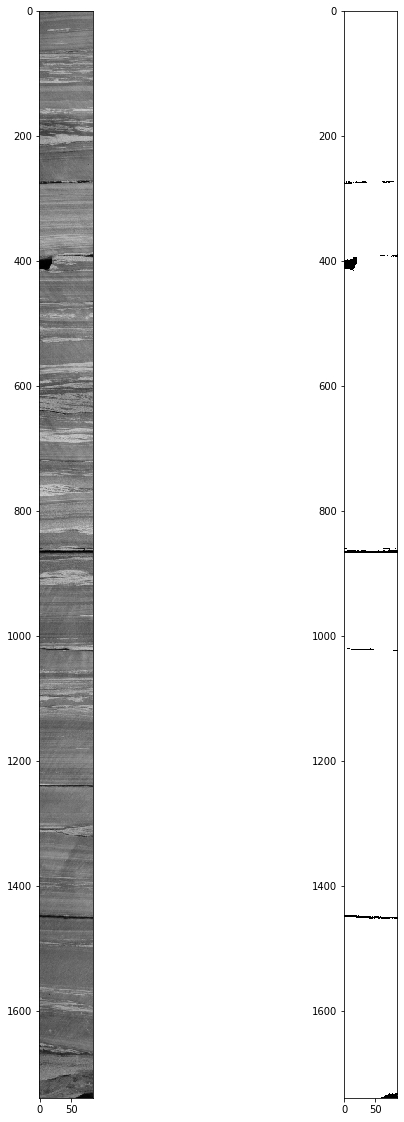

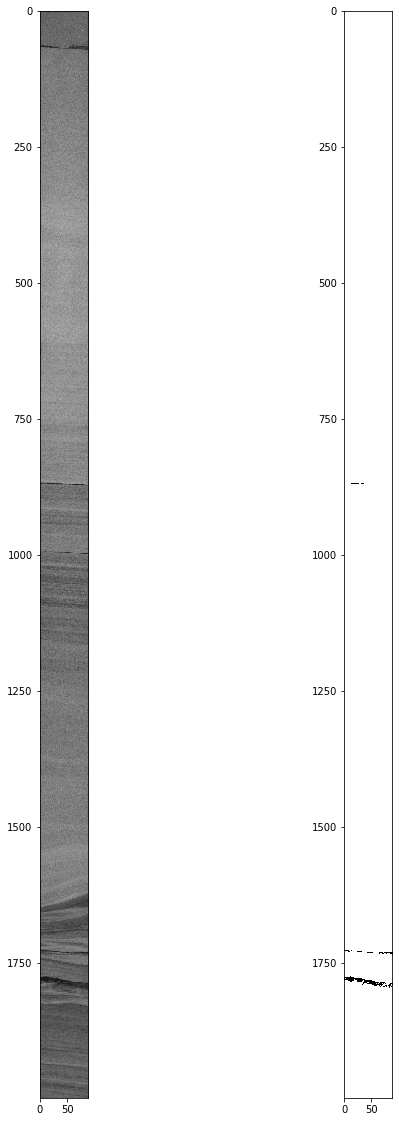

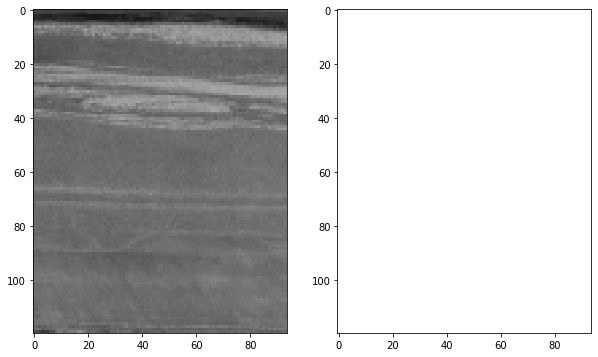

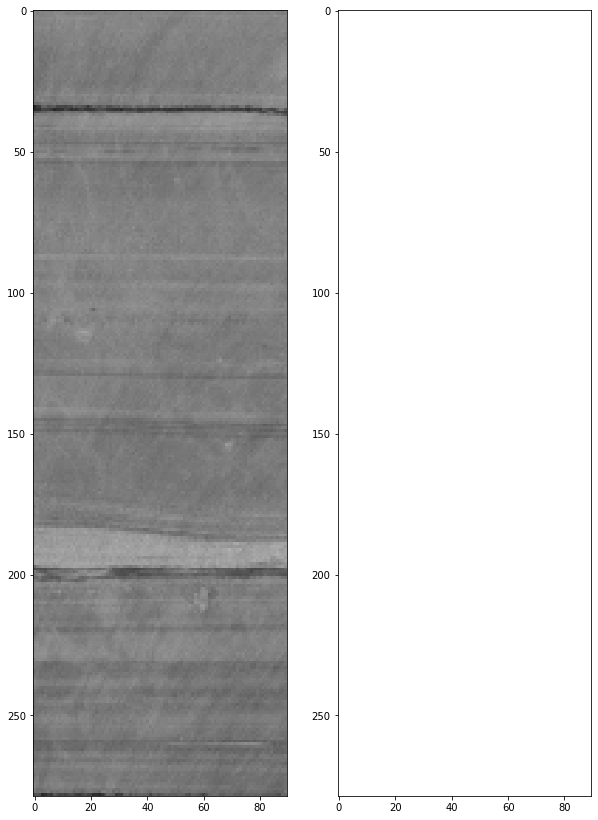

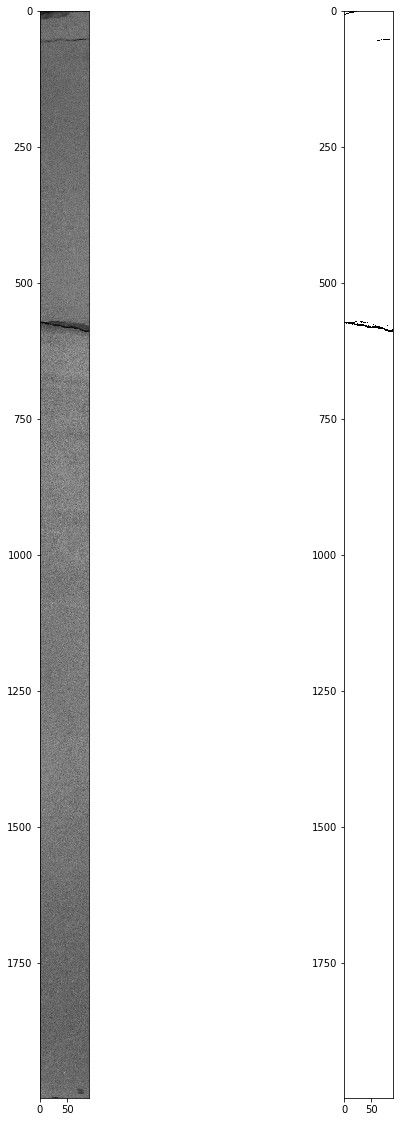

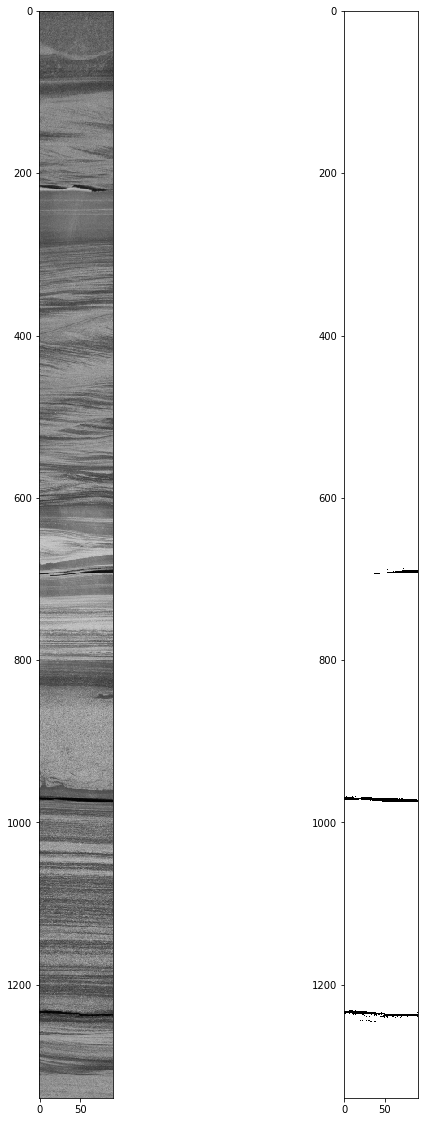

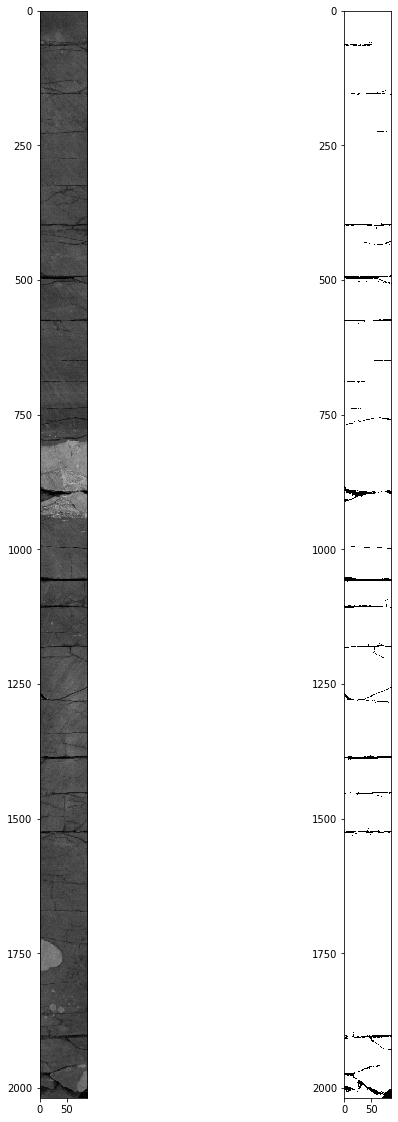

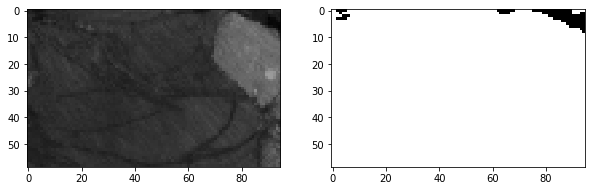

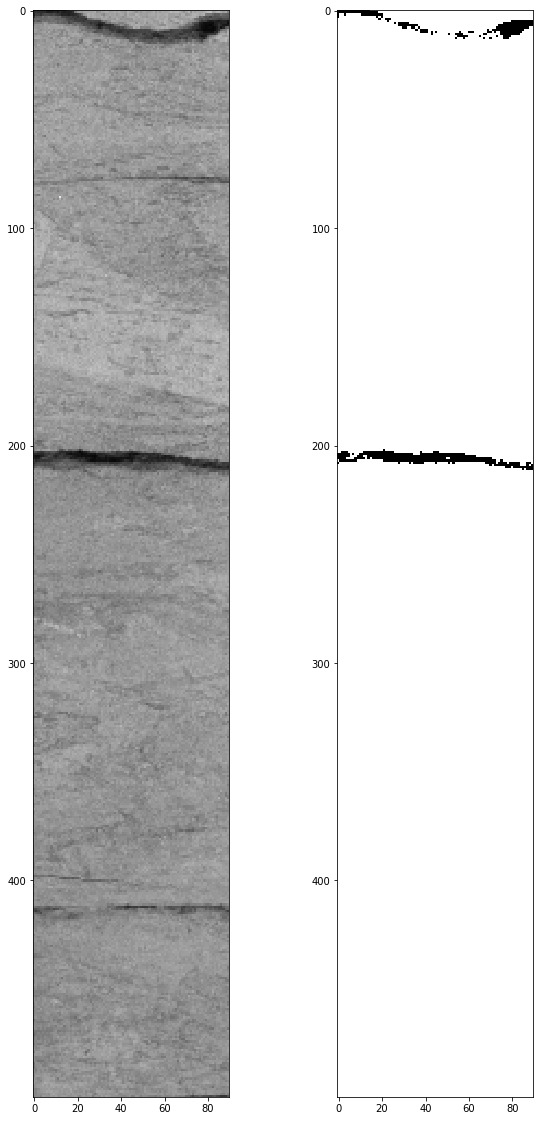

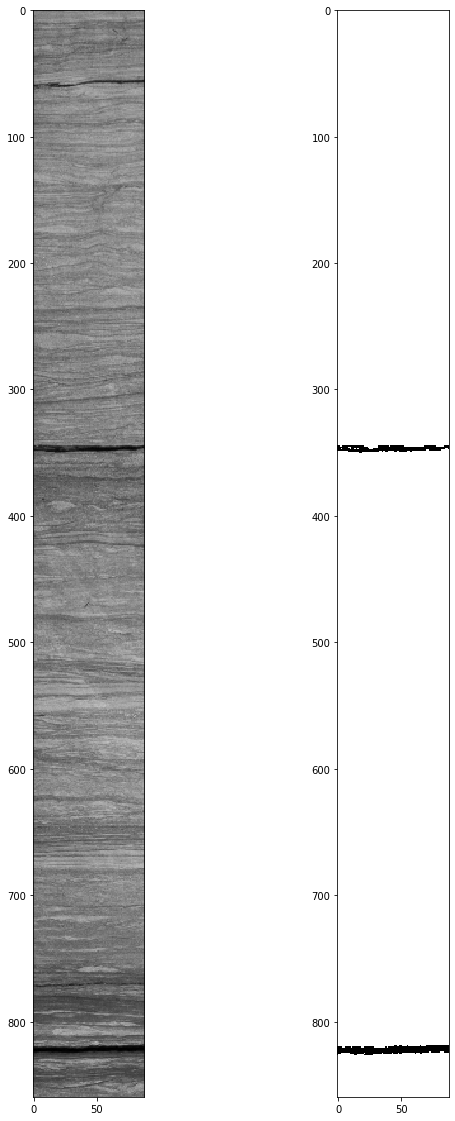

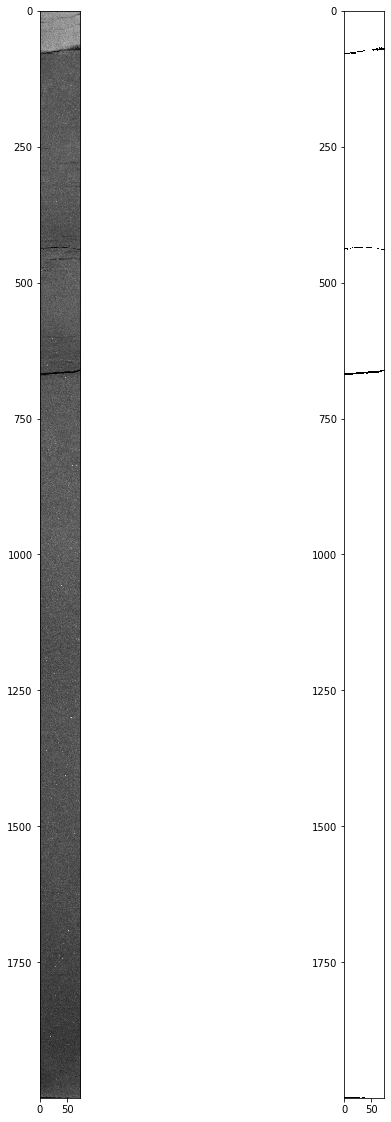

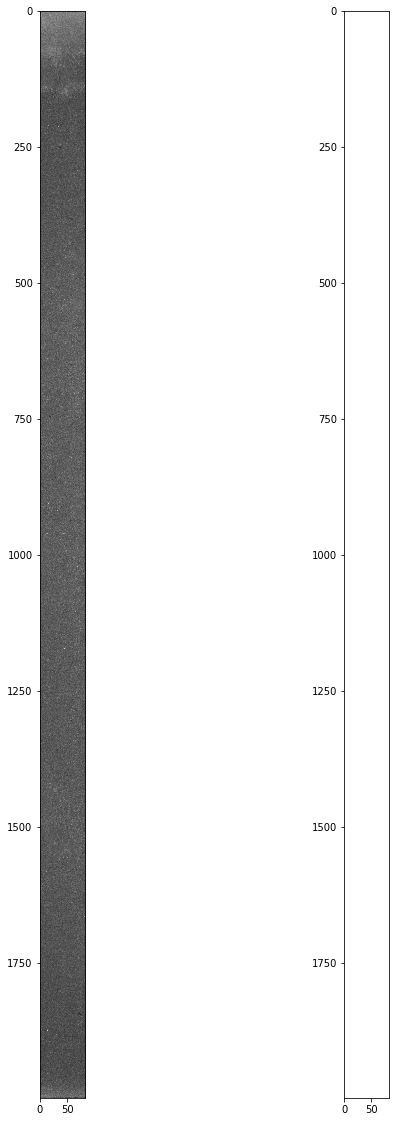

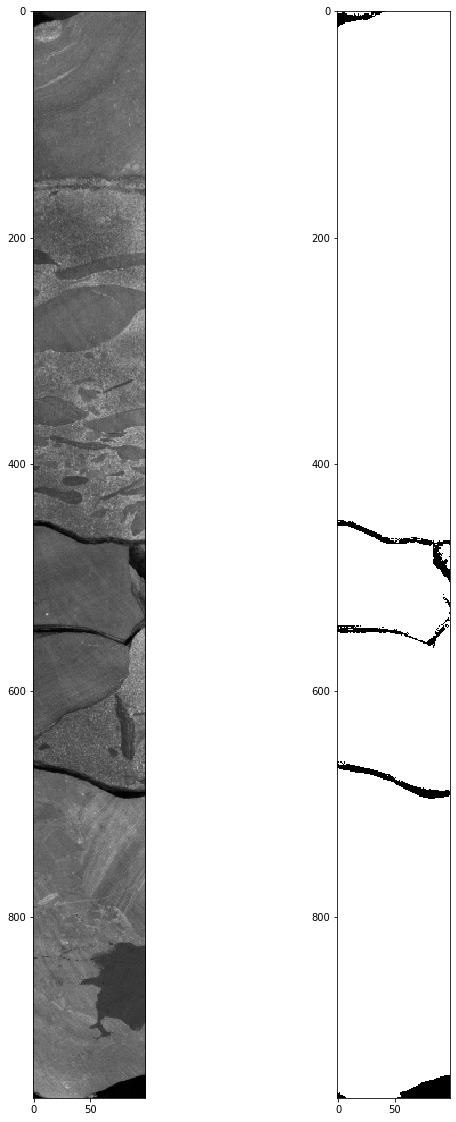

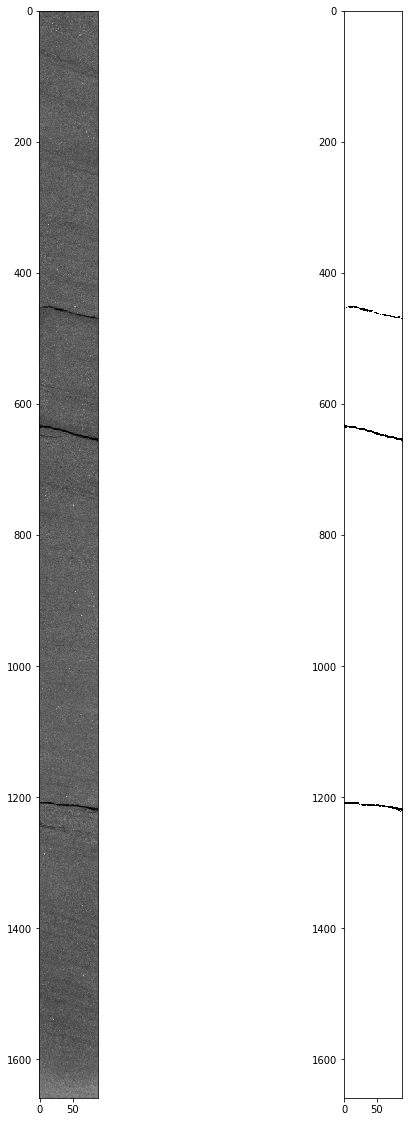

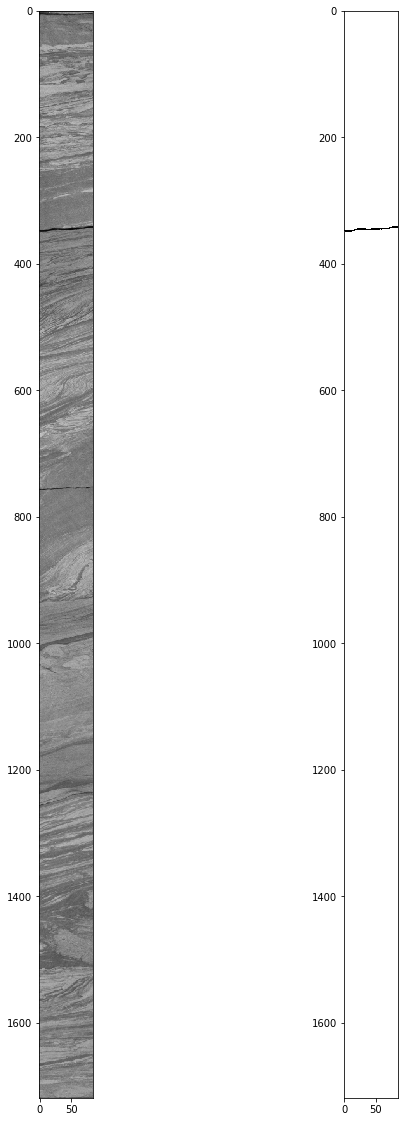

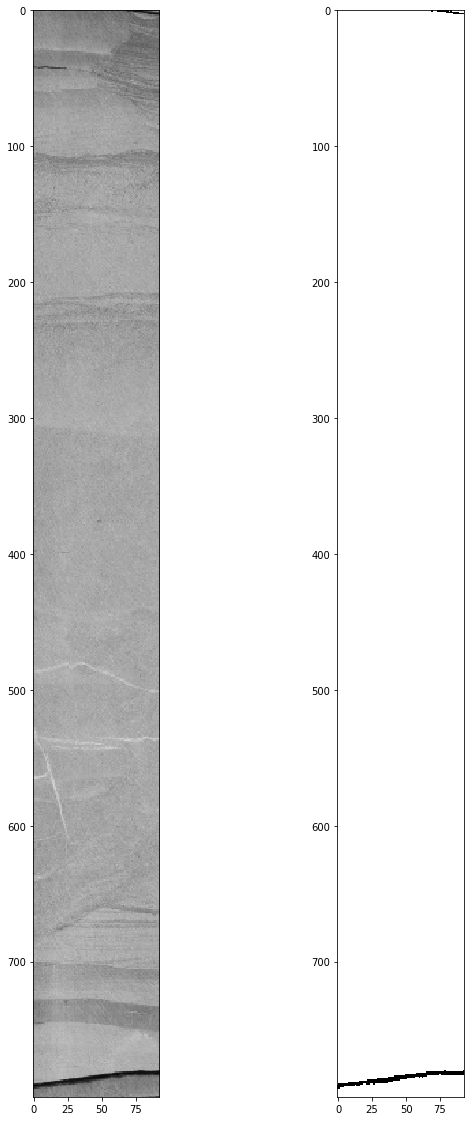

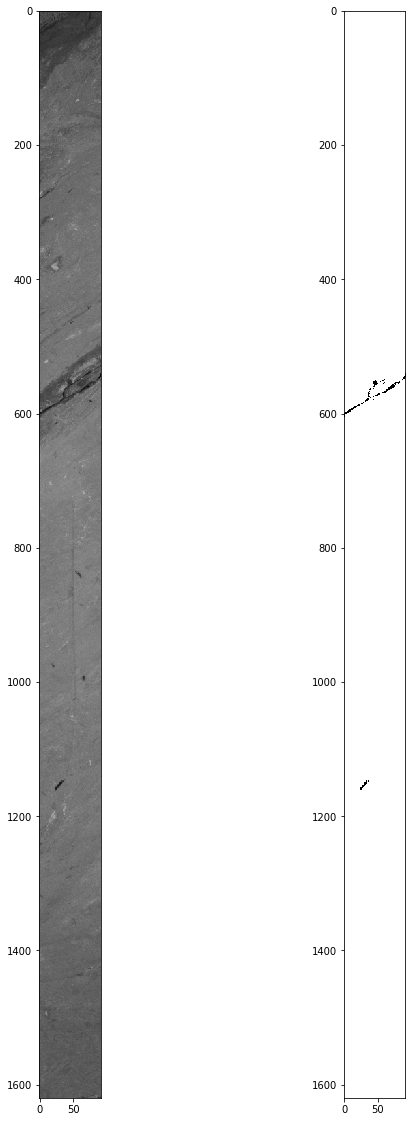

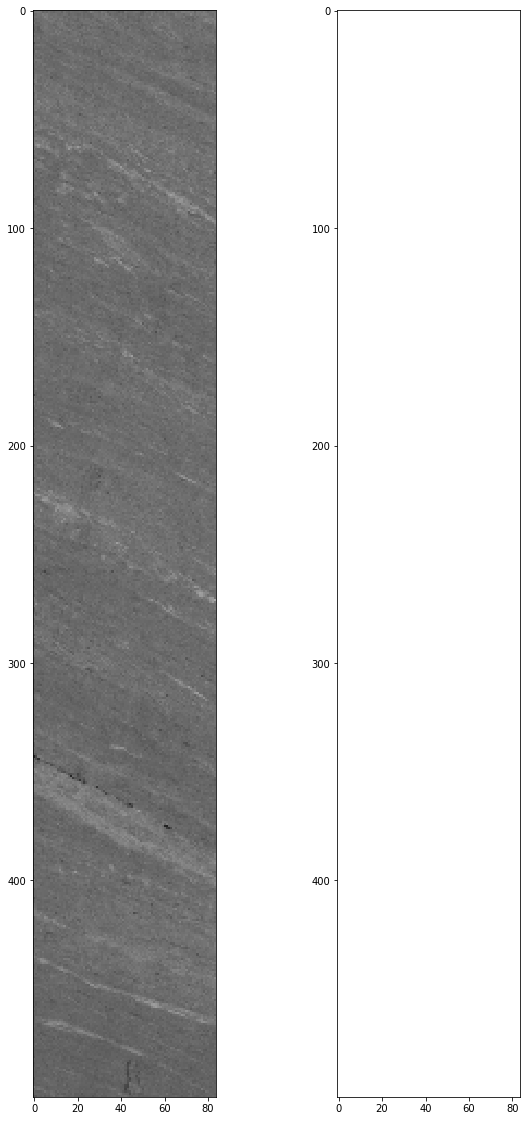

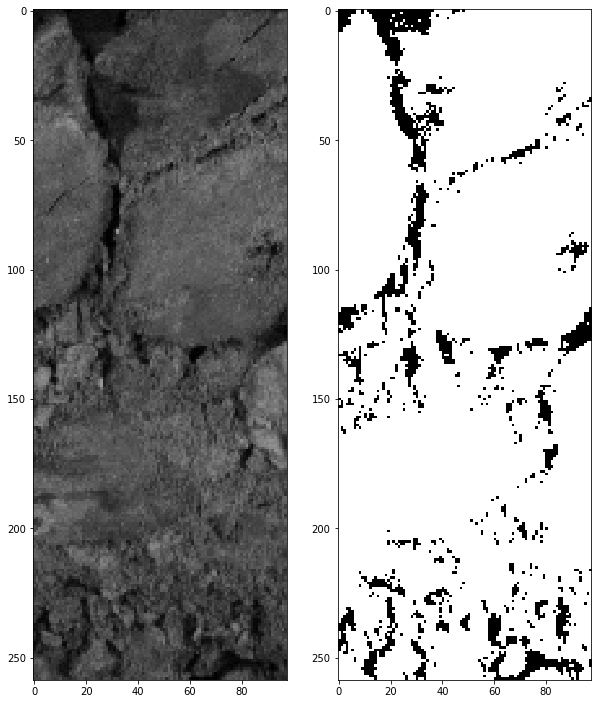

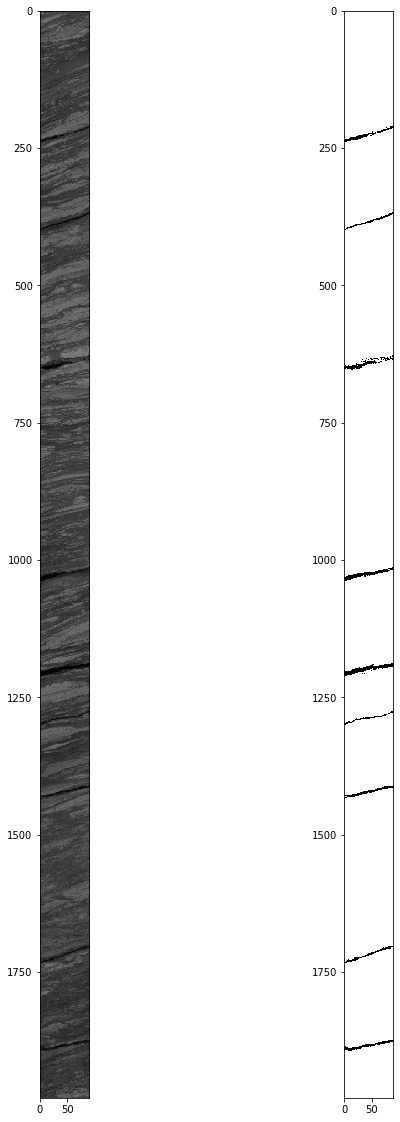

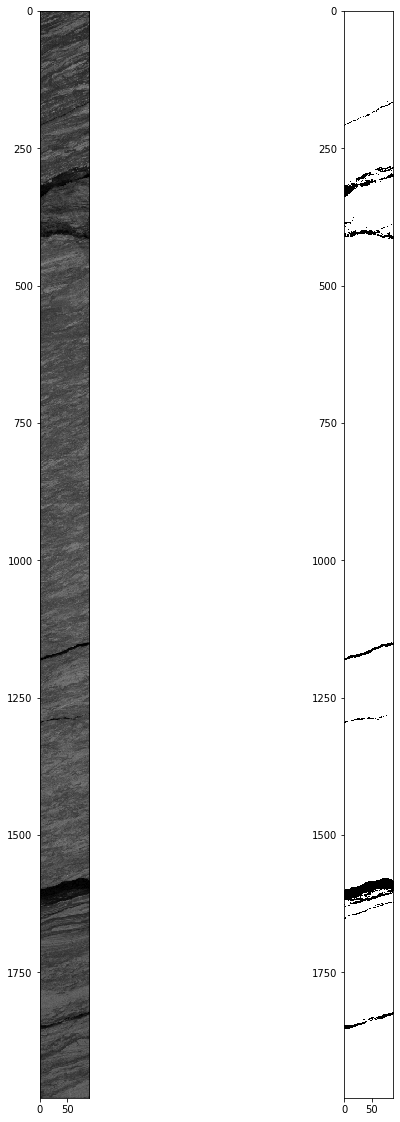

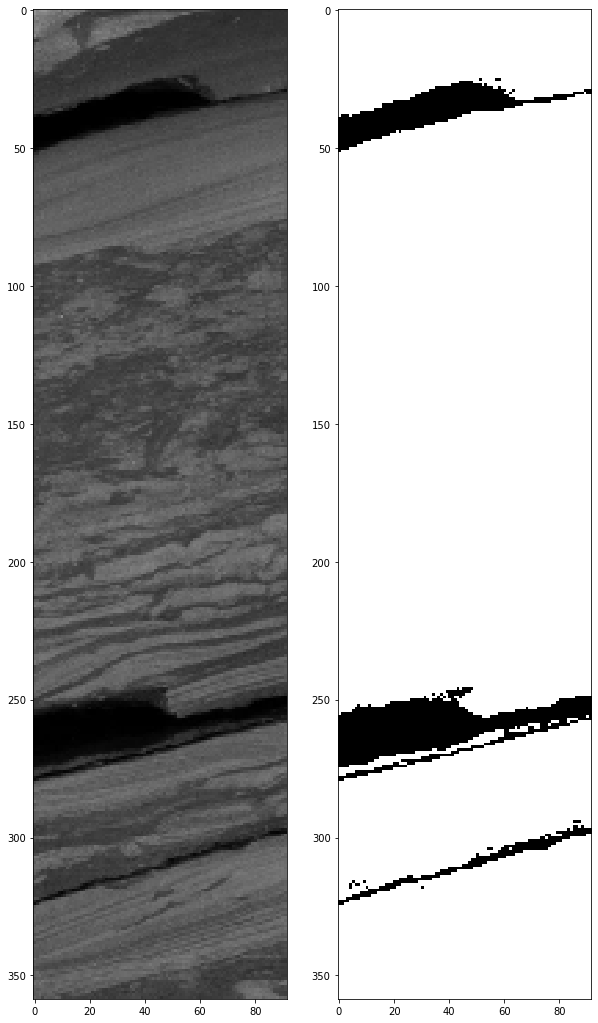

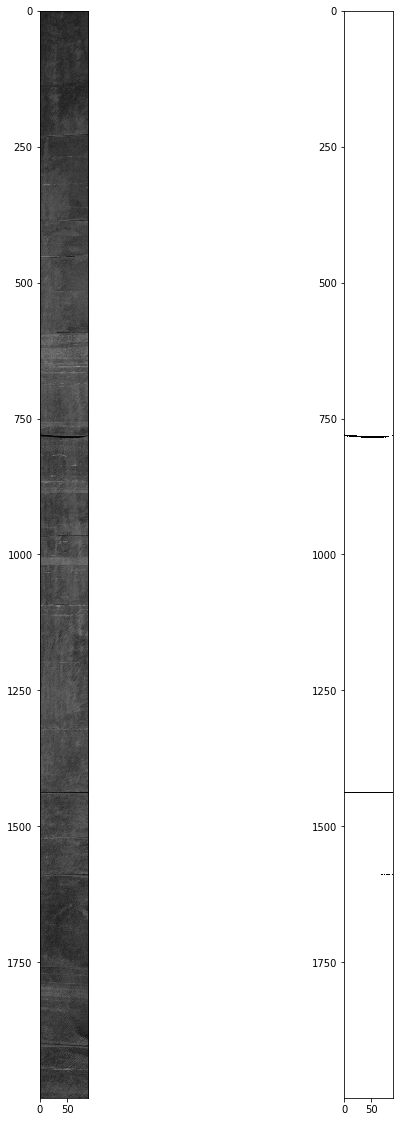

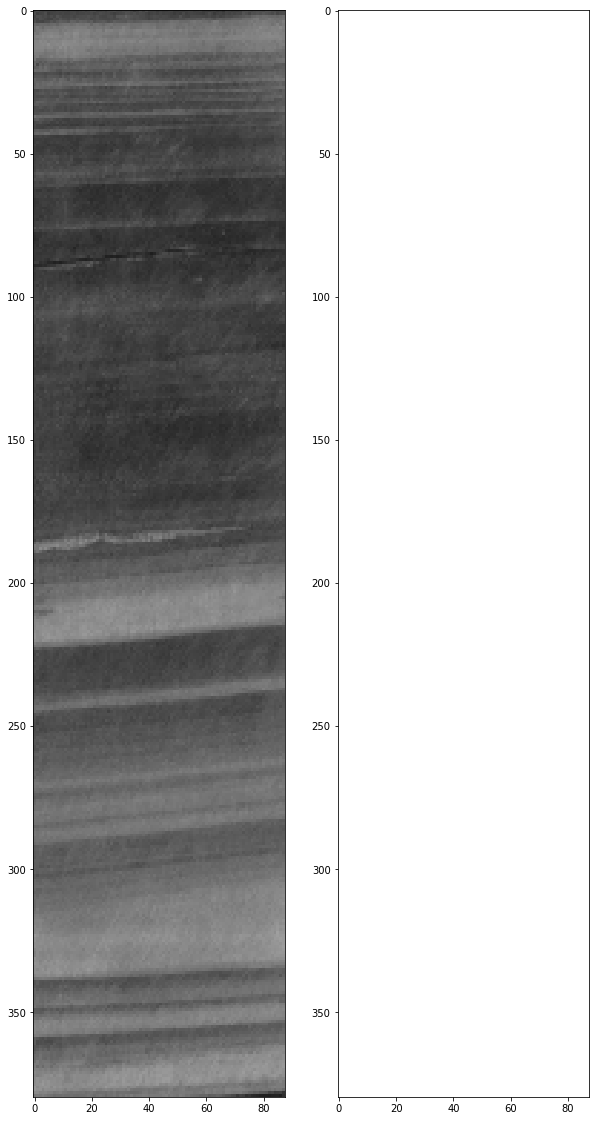

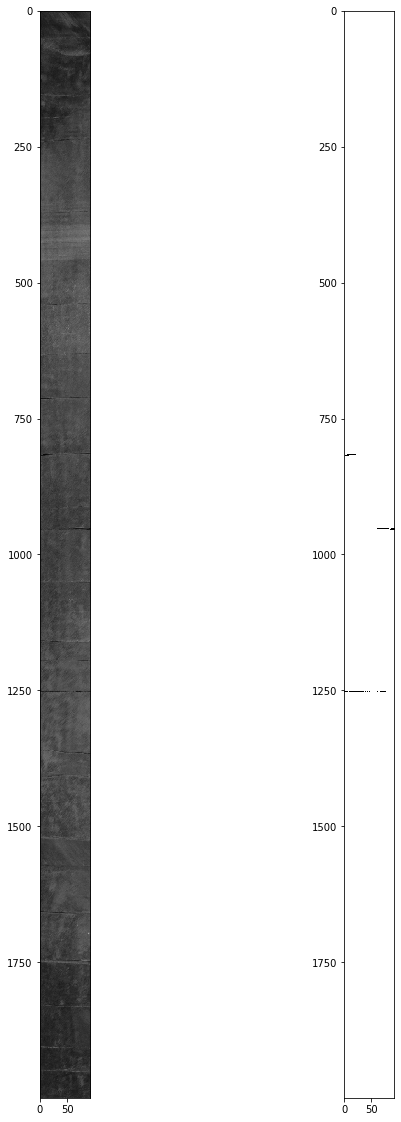

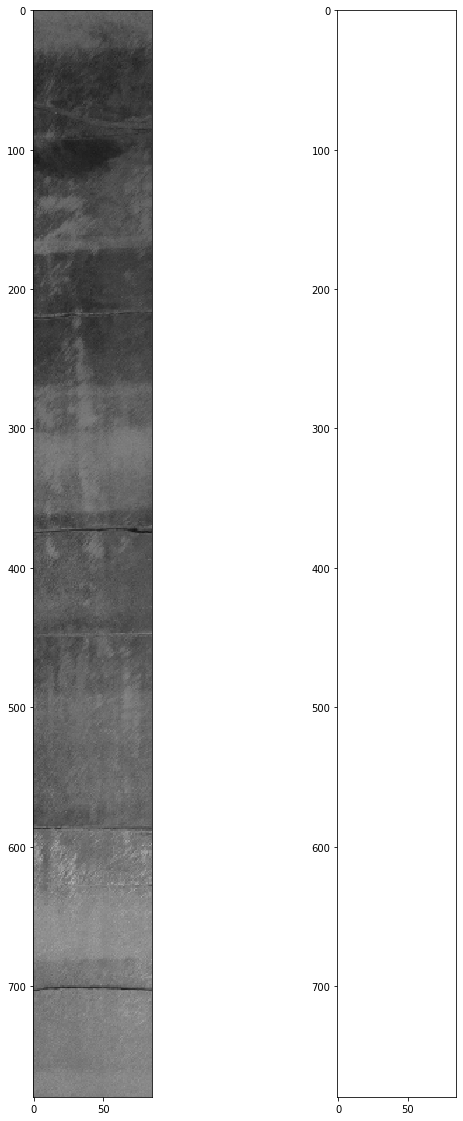

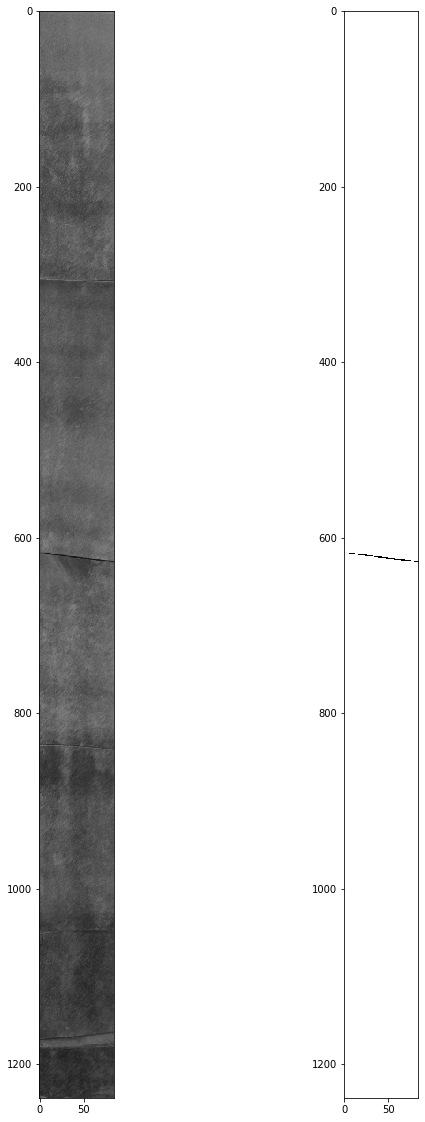

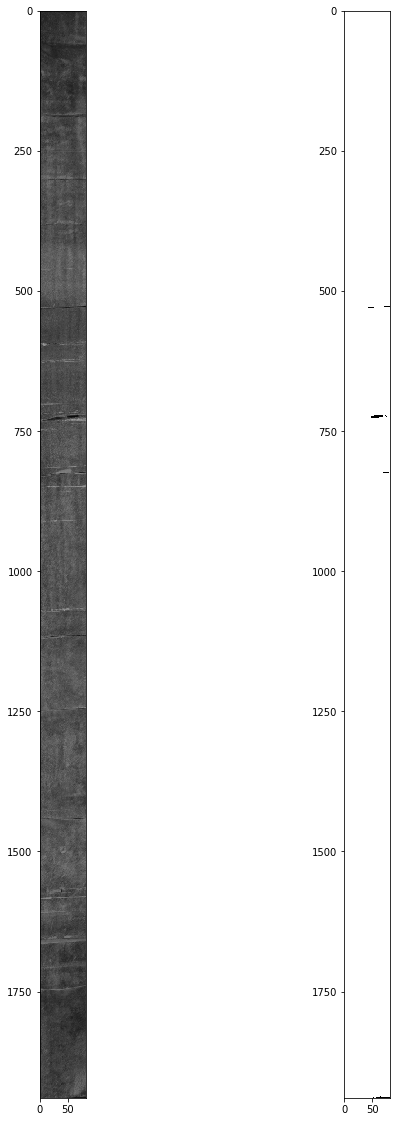

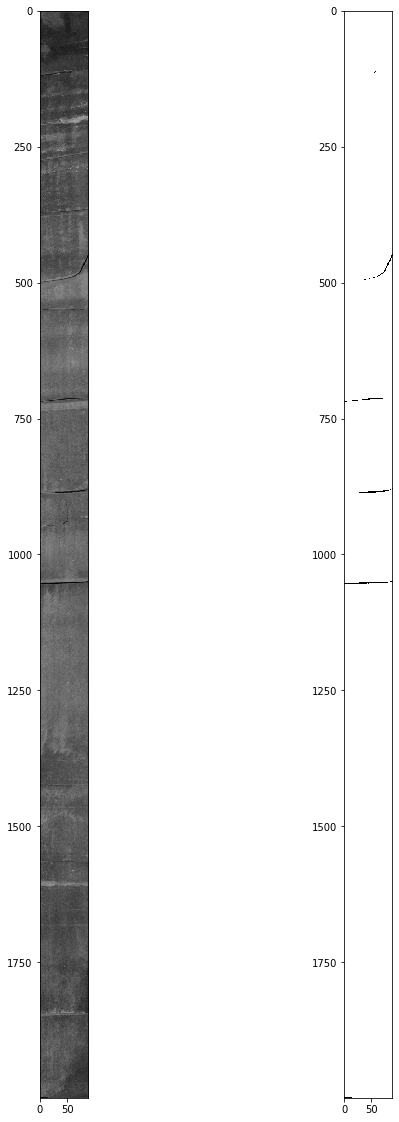

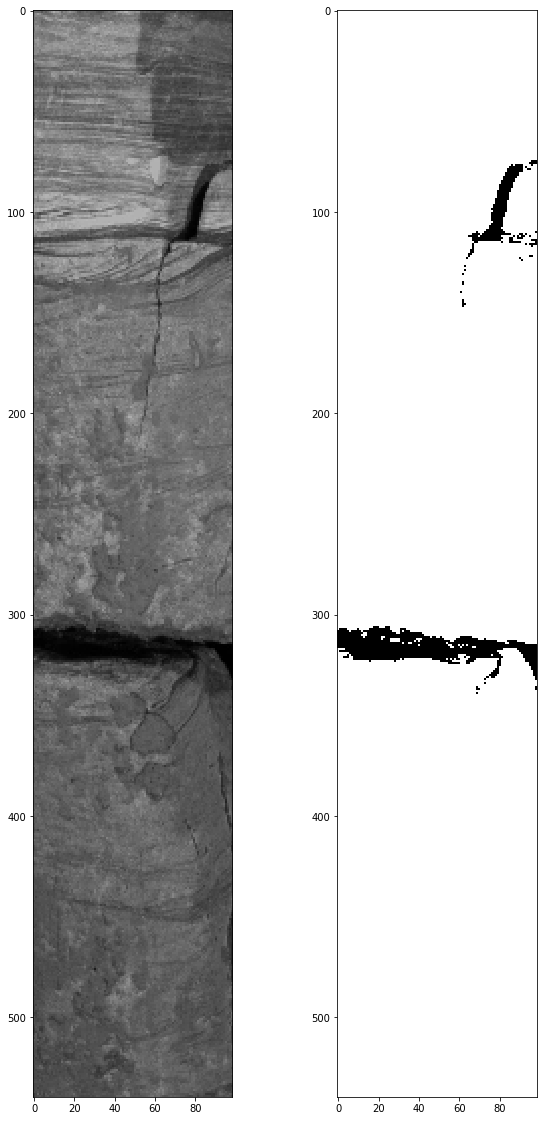

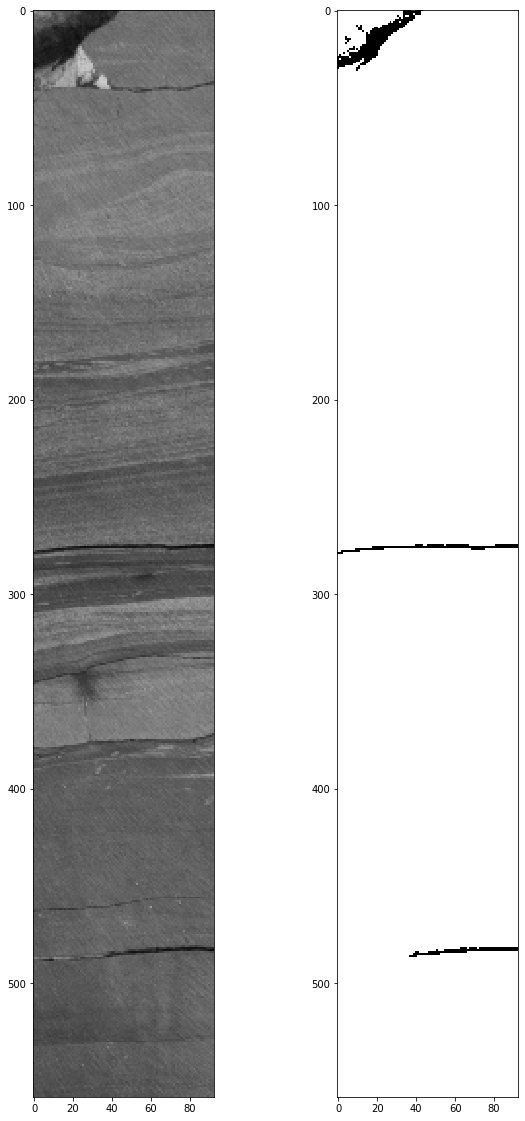

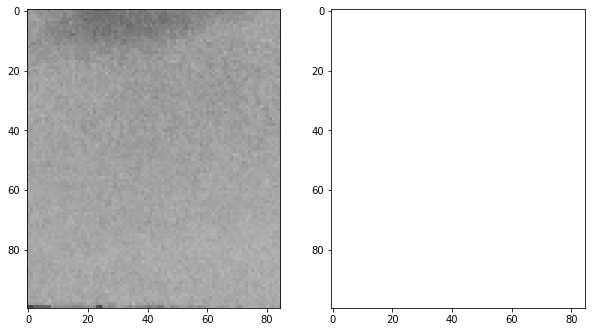

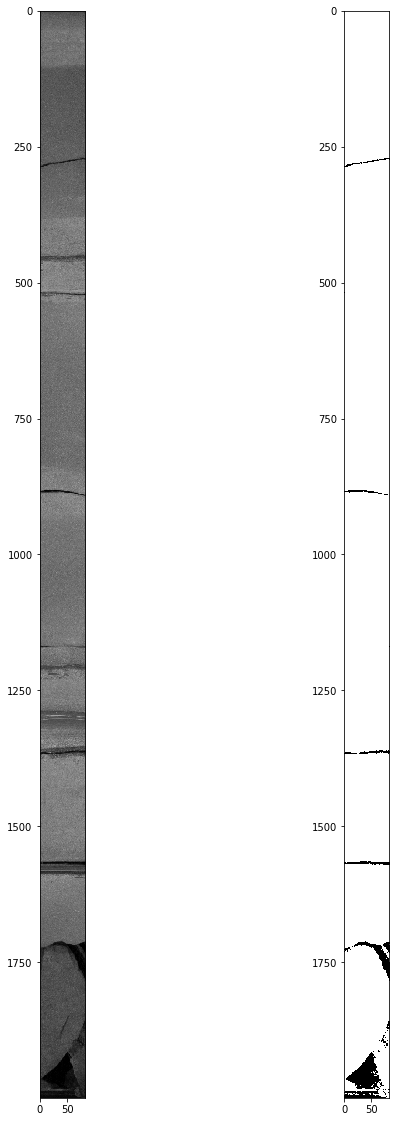

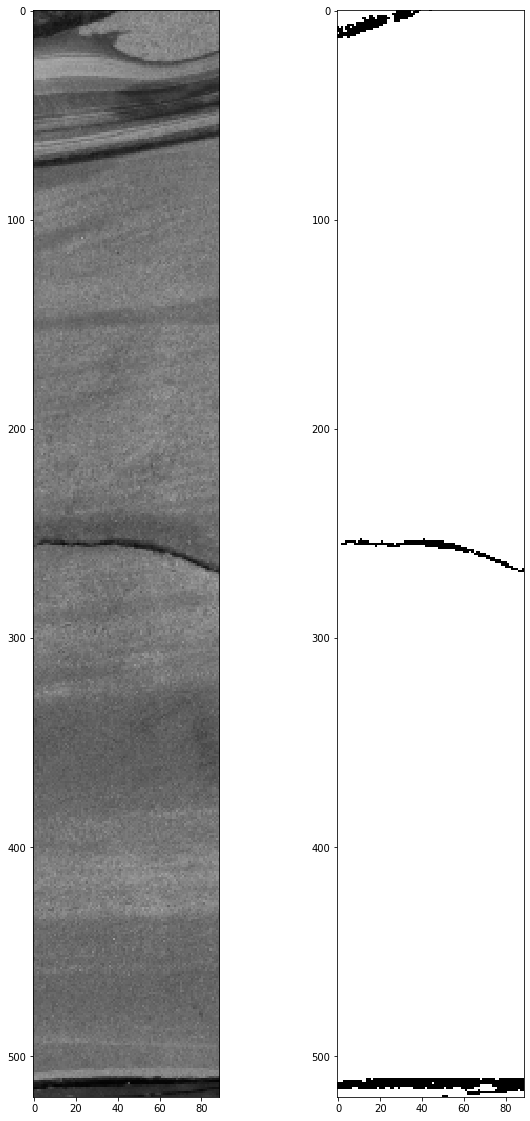

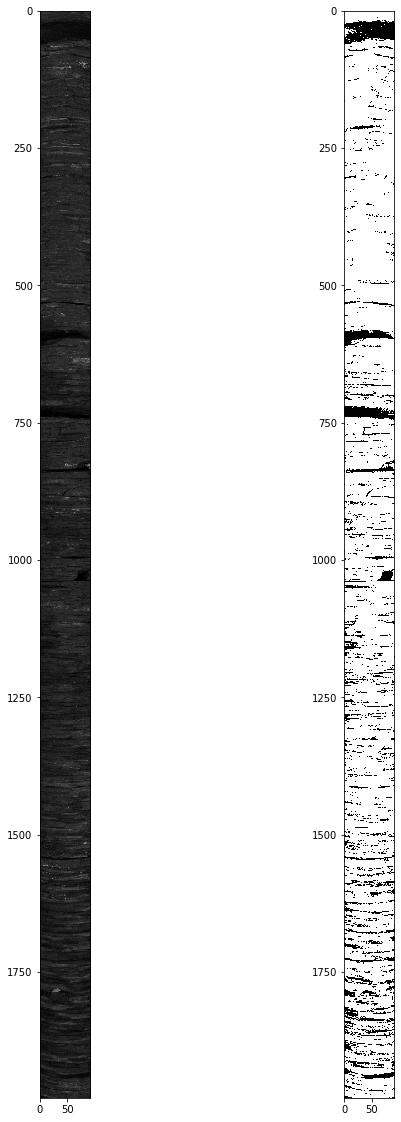

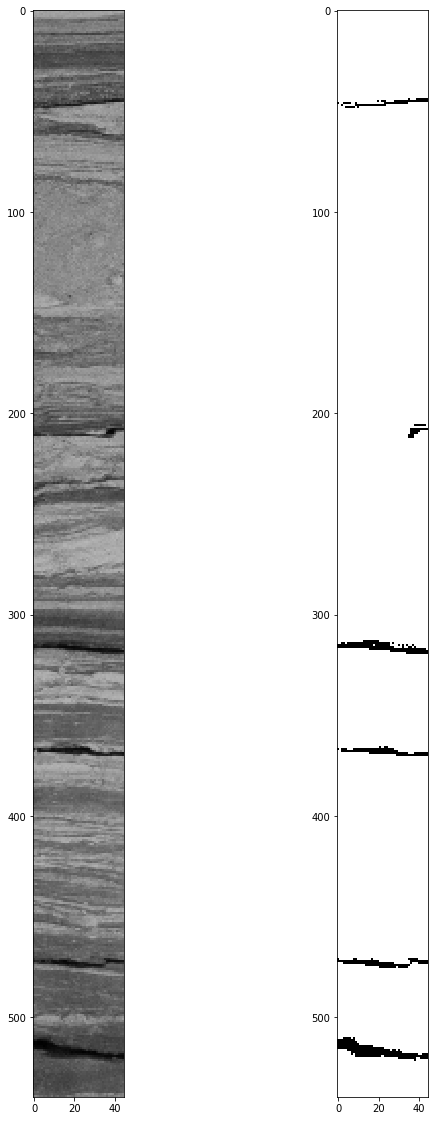

In [22]:
for index, row in df.iterrows():
    print(str(row["Id"])+" image")
    path = "{}/{}/data/{}.jpeg".format(WORK_DIR, row["Folder"],row["Id"])
    img = Image.open(path)
    
    absHeight = 100*(row["PhotoDown"]-row["PhotoTop"])
    
    img = scaleImg(img, absH=absHeight, res=RESOLUTION)
    img = np.asarray(img)[:,:,0]

    img = cropBorders(img, res=RESOLUTION)
    mask = crackMask(img)
    
    maskRGB = Image.fromarray(mask)
    maskRGB = maskRGB.convert("RGB")
    
    before = Image.fromarray(img)
    before = before.convert("RGB")
    
    fig,ax = plt.subplots(1, 2)
    ax[0].imshow(before)
    ax[1].imshow(maskRGB)